In [ ]:
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installation

In [ ]:
from sklearn.model_selection import train_test_split
import os
import random

import tensorflow as tf
import cv2
import numpy as np

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.losses import Loss
import tensorflow.keras.backend as K

**Build Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path ='/content/drive/MyDrive/AI/CPP/Unet detection/dataset'

In [ ]:
# Parameters
data_path  = file_path
w, h = 224, 224
batch_size = 32
img_size = (w, h)

In [ ]:
def load_path(data_path):
    # Get normal image and mask
    classes = ['Class1', 'Class2', 'Class3', 'Class4', 'Class5', 'Class6']

    # Lop qua cac thu muc khong loi
    normal_image_path = []
    normal_mask_path = []
    for class_ in classes:
        current_folder = os.path.join(data_path, class_)
        for file in os.listdir(current_folder):
            if file.endswith("png") and (not file.startswith(".")):
                image_path = os.path.join(current_folder, file)
                mask_path = os.path.join(current_folder + "_mask", file)
                normal_mask_path.append(mask_path)
                normal_image_path.append(image_path)

    # Get defect image and mask
    defect_image_path = []
    defect_mask_path = []
    for class_ in classes:
        class_ = class_ + "_def"
        current_folder = os.path.join(data_path, class_)
        for file in os.listdir(current_folder):
            if file.endswith("png") and (not file.startswith(".")):
                image_path = os.path.join(current_folder, file)
                mask_path = os.path.join(current_folder + "_mask", file)
                defect_mask_path.append(mask_path)
                defect_image_path.append(image_path) 

    idx = random.sample(range(len(normal_mask_path)), len(defect_mask_path))

    normal_mask_path_new = []
    normal_image_path_new = []

    for id in idx:
        normal_image_path_new.append(normal_image_path[id])
        normal_mask_path_new.append(normal_mask_path[id])

    image_path = normal_image_path_new + defect_image_path
    mask_path = normal_mask_path_new + defect_mask_path

    return image_path, mask_path

In [ ]:
image_path, mask_path = load_path(data_path)

In [ ]:
mask_path = [path for path in mask_path if "(" not in path]
image_path = [path for path in image_path if "(" not in path]

In [ ]:
matching_paths = [path for path in mask_path if "(" in path]

if matching_paths:
    print("Have path contain '(1)':")
    for path in matching_paths:
          print(path)
else:
    print("Don't have path contain '(1)'.")

In [ ]:
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io

In [ ]:
def get_dataset(batch_size, input_img_paths, target_img_paths, img_size):
    def load_img_masks(input_img_path, target_img_path):
        def _load_images(input_img_path, target_img_path):
       
            input_img_path = input_img_path.numpy().decode("utf-8")
            target_img_path = target_img_path.numpy().decode("utf-8")
         
            input_img = cv2.imread(input_img_path)
            input_img = cv2.resize(input_img, img_size)

            target_img = cv2.imread(target_img_path, cv2.IMREAD_UNCHANGED)
            target_img = cv2.resize(target_img, img_size)
            target_img = target_img.astype('float32') 
            target_img = np.expand_dims(target_img, axis=-1)

            return input_img, target_img
    
        input_img, target_img = tf.py_function(
            func=_load_images,
            inp=[input_img_path, target_img_path],
            Tout=[tf.float32, tf.float32],
        )
   
        input_img.set_shape([*img_size, 3])  # Input có 3 kênh màu
        target_img.set_shape([*img_size, 1])  # Mask có 1 kênh

        return input_img, target_img


    dataset = tf.data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.shuffle(buffer_size=len(input_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)

In [ ]:
image_train, image_test, mask_train, mask_test = train_test_split(image_path, mask_path, test_size=0.2)

In [ ]:
train_dataset = get_dataset(batch_size, image_train, mask_train, img_size)
test_dataset = get_dataset(batch_size, image_test, mask_test, img_size)

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

**Encoder Block**

In [ ]:
def stack_fn(x):
    x = stack_residual_blocks_v1(x, 64, 3, stride1=1, name="conv2")
    x = stack_residual_blocks_v1(x, 128, 4, name="conv3")
    x = stack_residual_blocks_v1(x, 256, 6, name="conv4")
    return stack_residual_blocks_v1(x, 512, 3, name="conv5")

In [ ]:
def stack_residual_blocks_v1(x, filters, blocks, stride1=2, name=None):

    x = residual_block_v1(x, filters, stride=stride1, name=name + "_block1")
    for i in range(2, blocks + 1):
        x = residual_block_v1( x, filters, conv_shortcut=False, name=name + "_block" + str(i))
    return x

In [ ]:
def residual_block_v1( x, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None):

    if tf.keras.backend.image_data_format() == "channels_last":
        bn_axis = 3
    else:
        bn_axis = 1

    if conv_shortcut:
        shortcut = layers.Conv2D( 4 * filters, 1, strides=stride, name=name + "_0_conv")(x)
        shortcut = layers.BatchNormalization( axis=bn_axis, epsilon=1.001e-5, name=name + "_0_bn")(shortcut)
    else:
        shortcut = x

    x = layers.Conv2D(filters, 1, strides=stride, name=name + "_1_conv")(x)
    x = layers.BatchNormalization( axis=bn_axis, epsilon=1.001e-5, name=name + "_1_bn")(x)
    x = layers.Activation("relu", name=name + "_1_relu")(x)

    x = layers.Conv2D( filters, kernel_size, padding="SAME", name=name + "_2_conv")(x)
    x = layers.BatchNormalization( axis=bn_axis, epsilon=1.001e-5, name=name + "_2_bn")(x)
    x = layers.Activation("relu", name=name + "_2_relu")(x)

    x = layers.Conv2D(4 * filters, 1, name=name + "_3_conv")(x)
    x = layers.BatchNormalization( axis=bn_axis, epsilon=1.001e-5, name=name + "_3_bn")(x)

    x = layers.Add(name=name + "_add")([shortcut, x])
    x = layers.Activation("relu", name=name + "_out")(x)
    return x

In [ ]:
def create_resnet50_backbone(input_shape=(224, 224, 3), weights='imagenet', include_top=False, trainable_bn=True, encoder_freeze=True):
    bn_axis = 3 if tf.keras.backend.image_data_format() == 'channels_last' else 1

    img_input = layers.Input(shape=input_shape, name='input')

    x = layers.ZeroPadding2D(padding=(3, 3), name="conv1_pad")(img_input)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), name='conv1_conv', use_bias=True)(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name="conv1_bn")(x)
    x = layers.Activation('relu', name="conv1_relu")(x)
    x = layers.ZeroPadding2D(padding=(1, 1), name="pool1_pad")(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), name="pool1_pool")(x)

    x = stack_fn(x)

    if include_top:
        x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        x = layers.Dense(1000, activation='softmax')(x)

    model = models.Model(img_input, x, name='resnet50_backbone')

    # Load weights
    if weights == 'imagenet':
        weights_path = tf.keras.utils.get_file(
            'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
            'https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
        )
        model.load_weights(weights_path, by_name=True) 
    elif os.path.exists(weights):
        model.load_weights(weights)

    if encoder_freeze:
        for layer in model.layers:
            if isinstance(layer, layers.BatchNormalization):
                layer.trainable = trainable_bn
            else:
                layer.trainable = False

    return model

**Build Unet**

In [ ]:
def create_resnet50_unet(input_shape=(224, 224, 3), num_classes=2):   
    # create encoder from ResNet50 backbone
    encoder = create_resnet50_backbone(input_shape=input_shape, weights='imagenet', include_top=False)

    # Input (224x224) -> conv1 (112x112) -> conv2 (56x56) -> conv3 (28x28) -> conv4 (14x14) -> conv5 (7x7)
    skip_connections = []
    layer_names = ['conv2_block3_out',  # 56x56
                   'conv3_block4_out',   # 28x28
                   'conv4_block6_out',     # 14x14
                   'conv1_relu']    # 112 x 112

    for name in layer_names:
        skip_connections.append(encoder.get_layer(name).output)
   
    x = encoder.output

    # Upsampling block 1: 7x7 -> 14x14
    x = layers.UpSampling2D(size=(2, 2))(x)  # 14x14
    x = layers.Concatenate()([x, skip_connections[2]])
    x = layers.Conv2D(512, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Upsampling block 2: 14x14 -> 28x28
    x = layers.UpSampling2D(size=(2, 2))(x)  # 28x28
    x = layers.Concatenate()([x, skip_connections[1]])
    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Upsampling block 3: 28x28 -> 56x56
    x = layers.UpSampling2D(size=(2, 2))(x)  # 56x56
    x = layers.Concatenate()([x, skip_connections[0]])
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Upsampling block 4: 56x56 -> 112x112
    x = layers.UpSampling2D(size=(2, 2))(x)  # 112x112
    x = layers.Concatenate()([x, skip_connections[3]])
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Final upsampling: 112x112 -> 224x224
    x = layers.UpSampling2D(size=(2, 2))(x)  # 224x224
    x = layers.Conv2D(32, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Output layer
    if num_classes == 2:
        x = layers.Conv2D(1, 1)(x)  # Binary segmentation
        x = layers.Activation('sigmoid')(x)
    else:
        x = layers.Conv2D(num_classes, 1)(x)
        x = layers.Activation('softmax')(x)

    # Create model
    model = models.Model(inputs=encoder.input, outputs=x)

    return model

**Build Loss**

In [ ]:
SMOOTH = 1e-5

In [ ]:
def _gather_channels(x, indexes, **kwargs):  

    if K.image_data_format() == 'channels_last':
        x = K.permute_dimensions(x, (3, 0, 1, 2))
        x = K.gather(x, indexes)
        x = K.permute_dimensions(x, (1, 2, 3, 0))
    else:
        x = K.permute_dimensions(x, (1, 0, 2, 3))
        x = K.gather(x, indexes)
        x = K.permute_dimensions(x, (1, 0, 2, 3))
    return x
def gather_channels(*xs, indexes=None, **kwargs):
    
    if indexes is None:
        return xs
    elif isinstance(indexes, (int)):
        indexes = [indexes]
    xs = [_gather_channels(x, indexes=indexes, **kwargs) for x in xs]
    return xs
def round_if_needed(x, threshold, **kwargs):
    if threshold is not None:
        x = K.greater(x, threshold)
        x = K.cast(x, K.floatx())
    return x
def get_reduce_axes(per_image, **kwargs):
    axes = [1, 2] if K.image_data_format() == 'channels_last' else [2, 3]
    if not per_image:
        axes.insert(0, 0)
    return axes
def average(x, per_image=False, class_weights=None, **kwargs):
    if per_image:
        x = K.mean(x, axis=0)
    if class_weights is not None:
        x = x * class_weights
    return K.mean(x)

In [ ]:
class UNetLoss(Loss):
    def __init__(self, beta=1, class_weights=None, class_indexes=None, per_image=False, smooth=SMOOTH, alpha=0.25, gamma=2.):
        super().__init__(name='dice_loss')
        self.beta = beta
        self.class_weights = class_weights if class_weights is not None else 1
        self.class_indexes = class_indexes
        self.per_image = per_image
        self.smooth = smooth

        self.alpha = alpha
        self.gamma = gamma

    def dice_loss(self, gt, pr):
        return 1 - self.f_score(
            gt,
            pr,
            beta=self.beta,
            class_weights=self.class_weights,
            class_indexes=self.class_indexes,
            smooth=self.smooth,
            per_image=self.per_image,
            threshold=None
        )
    def f_score(self, gt, pr, beta=1, class_weights=1, class_indexes=None, smooth=SMOOTH, per_image=False, threshold=None,
                **kwargs):

        gt, pr = gather_channels(gt, pr, indexes=class_indexes, **kwargs)
        pr = round_if_needed(pr, threshold, **kwargs)
        axes = get_reduce_axes(per_image, **kwargs)

        # calculate score
        tp = K.sum(gt * pr, axis=axes)
        fp = K.sum(pr, axis=axes) - tp
        fn = K.sum(gt, axis=axes) - tp

        score = ((1 + beta ** 2) * tp + smooth) \
                / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth)
        score = average(score, per_image, class_weights, **kwargs)

        return score

    def focal_loss(self, gt, pr):
        return self.binary_focal_loss(gt, pr, alpha=self.alpha, gamma=self.gamma)

    def categorical_focal_loss(self, y_true, y_pred, gamma=2.0, alpha=0.25, **kwargs):
      y_true, y_pred = gather_channels(y_true, y_pred, indexes=self.class_indexes, **kwargs)

      # clip to prevent NaN's and Inf's
      y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())

      # Calculate focal loss
      loss = - y_true * (alpha * K.pow((1 - y_pred), gamma) * K.log(y_pred))

      return K.mean(loss)

    def call(self, y_true, y_pred):
      dice = self.dice_loss(y_true, y_pred)
      focal = self.categorical_focal_loss(y_true, y_pred)
      total_loss = dice + focal
      return total_loss

**Build Metric**

In [ ]:
class IOUScore(tf.keras.metrics.Metric):
    def __init__(self, class_weights=1, class_indexes=None, threshold=None, per_image=False, smooth=1e-6, name='iou_score', dtype=None):
        super(IOUScore, self).__init__(name=name, dtype=dtype)
        self.class_weights = class_weights if class_weights is not None else 1
        self.class_indexes = class_indexes
        self.threshold = threshold
        self.per_image = per_image
        self.smooth = smooth

        self.total_intersection = self.add_weight(name='total_intersection', initializer='zeros')
        self.total_union = self.add_weight(name='total_union', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):

        y_true, y_pred = gather_channels(y_true, y_pred, indexes=self.class_indexes)
        y_pred = round_if_needed(y_pred, self.threshold)
        axes = get_reduce_axes(self.per_image)

        intersection = K.sum(y_true * y_pred, axis=axes)
        union = K.sum(y_true + y_pred, axis=axes) - intersection

        intersection = K.sum(intersection)
        union = K.sum(union)

        self.total_intersection.assign_add(intersection)
        self.total_union.assign_add(union)

    def result(self):
        iou = (self.total_intersection + self.smooth) / (self.total_union + self.smooth)
        return average(iou, self.per_image, self.class_weights)

    def reset_state(self):
        self.total_intersection.assign(0)
        self.total_union.assign(0)


**Training**

In [ ]:
def train_unet(train_dataset, val_dataset, input_shape=(224, 224, 3), epochs=1):

    model = create_resnet50_unet(input_shape=input_shape)
    loss_fn = UNetLoss(beta=1.0, alpha=0.25, gamma=2.0)

    model.compile(optimizer='adam', loss=loss_fn)
    iou_metric = IOUScore(threshold=0.5)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=loss_fn,
        metrics=[iou_metric]
    )

    # Callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.weights.h5',
            monitor='val_dice_coefficient',
            mode='max',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            verbose=1
        )
    ]

    # Training
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=test_dataset,
        callbacks=callbacks
    )
    return model, history

In [ ]:
model, history = train_unet(train_dataset, test_dataset, epochs=100)

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 0.9463 - iou_score: 0.0366

45/45 [==============================] - 191s 3s/step - loss: 0.9463 - iou_score: 0.0366 - val_loss: 0.9727 - val_iou_score: 0.0129 - lr: 1.0000e-04
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 0.9109 - iou_score: 0.1543

45/45 [==============================] - 37s 825ms/step - loss: 0.9109 - iou_score: 0.1543 - val_loss: 0.9609 - val_iou_score: 0.0229 - lr: 1.0000e-04
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 0.8940 - iou_score: 0.2435

45/45 [==============================] - 37s 813ms/step - loss: 0.8940 - iou_score: 0.2435 - val_loss: 0.9441 - val_iou_score: 0.1003 - lr: 1.0000e-04
Epoch 4/100
45/45 [==============================] - ETA: 0s - loss: 0.8820 - iou_score: 0.3139

45/45 [==============================] - 37s 822ms/step - loss: 0.8820 - iou_score: 0.3139 - val_loss: 0.9297 - val_iou_score: 0.2667 - lr: 1.0000e-04
Epoch 5/100
45/45 [==============================] - ETA: 0s - loss: 0.8714 - iou_score: 0.3628

45/45 [==============================] - 37s 814ms/step - loss: 0.8714 - iou_score: 0.3628 - val_loss: 0.9220 - val_iou_score: 0.1879 - lr: 1.0000e-04
Epoch 6/100
45/45 [==============================] - ETA: 0s - loss: 0.8614 - iou_score: 0.4009

45/45 [==============================] - 37s 823ms/step - loss: 0.8614 - iou_score: 0.4009 - val_loss: 0.9095 - val_iou_score: 0.2958 - lr: 1.0000e-04
Epoch 7/100
45/45 [==============================] - ETA: 0s - loss: 0.8524 - iou_score: 0.4357

45/45 [==============================] - 37s 816ms/step - loss: 0.8524 - iou_score: 0.4357 - val_loss: 0.8997 - val_iou_score: 0.3519 - lr: 1.0000e-04
Epoch 8/100
45/45 [==============================] - ETA: 0s - loss: 0.8431 - iou_score: 0.4502

45/45 [==============================] - 37s 818ms/step - loss: 0.8431 - iou_score: 0.4502 - val_loss: 0.8904 - val_iou_score: 0.3326 - lr: 1.0000e-04
Epoch 9/100
45/45 [==============================] - ETA: 0s - loss: 0.8335 - iou_score: 0.4805

45/45 [==============================] - 37s 820ms/step - loss: 0.8335 - iou_score: 0.4805 - val_loss: 0.8880 - val_iou_score: 0.2218 - lr: 1.0000e-04
Epoch 10/100
45/45 [==============================] - ETA: 0s - loss: 0.8211 - iou_score: 0.5266

45/45 [==============================] - 37s 820ms/step - loss: 0.8211 - iou_score: 0.5266 - val_loss: 0.8619 - val_iou_score: 0.4300 - lr: 1.0000e-04
Epoch 11/100
45/45 [==============================] - ETA: 0s - loss: 0.8088 - iou_score: 0.5334

45/45 [==============================] - 37s 819ms/step - loss: 0.8088 - iou_score: 0.5334 - val_loss: 0.8404 - val_iou_score: 0.4127 - lr: 1.0000e-04
Epoch 12/100
45/45 [==============================] - ETA: 0s - loss: 0.7956 - iou_score: 0.5545

45/45 [==============================] - 37s 820ms/step - loss: 0.7956 - iou_score: 0.5545 - val_loss: 0.8343 - val_iou_score: 0.4542 - lr: 1.0000e-04
Epoch 13/100
45/45 [==============================] - ETA: 0s - loss: 0.7813 - iou_score: 0.5704

45/45 [==============================] - 37s 818ms/step - loss: 0.7813 - iou_score: 0.5704 - val_loss: 0.8213 - val_iou_score: 0.4588 - lr: 1.0000e-04
Epoch 14/100
45/45 [==============================] - ETA: 0s - loss: 0.7667 - iou_score: 0.5972

45/45 [==============================] - 37s 815ms/step - loss: 0.7667 - iou_score: 0.5972 - val_loss: 0.8008 - val_iou_score: 0.3841 - lr: 1.0000e-04
Epoch 15/100
45/45 [==============================] - ETA: 0s - loss: 0.7503 - iou_score: 0.6072

45/45 [==============================] - 37s 818ms/step - loss: 0.7503 - iou_score: 0.6072 - val_loss: 0.7839 - val_iou_score: 0.4847 - lr: 1.0000e-04
Epoch 16/100
45/45 [==============================] - ETA: 0s - loss: 0.7271 - iou_score: 0.6256

45/45 [==============================] - 37s 817ms/step - loss: 0.7271 - iou_score: 0.6256 - val_loss: 0.7662 - val_iou_score: 0.4816 - lr: 1.0000e-04
Epoch 17/100
45/45 [==============================] - ETA: 0s - loss: 0.7074 - iou_score: 0.6619

45/45 [==============================] - 37s 823ms/step - loss: 0.7074 - iou_score: 0.6619 - val_loss: 0.7734 - val_iou_score: 0.4962 - lr: 1.0000e-04
Epoch 18/100
45/45 [==============================] - ETA: 0s - loss: 0.6863 - iou_score: 0.6884

45/45 [==============================] - 37s 818ms/step - loss: 0.6863 - iou_score: 0.6884 - val_loss: 0.7518 - val_iou_score: 0.4991 - lr: 1.0000e-04
Epoch 19/100
45/45 [==============================] - ETA: 0s - loss: 0.6608 - iou_score: 0.7039

45/45 [==============================] - 37s 821ms/step - loss: 0.6608 - iou_score: 0.7039 - val_loss: 0.7209 - val_iou_score: 0.5019 - lr: 1.0000e-04
Epoch 20/100
45/45 [==============================] - ETA: 0s - loss: 0.6386 - iou_score: 0.7347

45/45 [==============================] - 37s 819ms/step - loss: 0.6386 - iou_score: 0.7347 - val_loss: 0.7128 - val_iou_score: 0.4942 - lr: 1.0000e-04
Epoch 21/100
45/45 [==============================] - ETA: 0s - loss: 0.6187 - iou_score: 0.7396

45/45 [==============================] - 37s 820ms/step - loss: 0.6187 - iou_score: 0.7396 - val_loss: 0.7046 - val_iou_score: 0.5031 - lr: 1.0000e-04
Epoch 22/100
45/45 [==============================] - ETA: 0s - loss: 0.5895 - iou_score: 0.7553

45/45 [==============================] - 37s 821ms/step - loss: 0.5895 - iou_score: 0.7553 - val_loss: 0.6698 - val_iou_score: 0.5139 - lr: 1.0000e-04
Epoch 23/100
45/45 [==============================] - ETA: 0s - loss: 0.5634 - iou_score: 0.7750

45/45 [==============================] - 37s 820ms/step - loss: 0.5634 - iou_score: 0.7750 - val_loss: 0.6818 - val_iou_score: 0.4919 - lr: 1.0000e-04
Epoch 24/100
45/45 [==============================] - ETA: 0s - loss: 0.5359 - iou_score: 0.7879

45/45 [==============================] - 37s 816ms/step - loss: 0.5359 - iou_score: 0.7879 - val_loss: 0.6555 - val_iou_score: 0.4978 - lr: 1.0000e-04
Epoch 25/100
45/45 [==============================] - ETA: 0s - loss: 0.5104 - iou_score: 0.7912

45/45 [==============================] - 37s 820ms/step - loss: 0.5104 - iou_score: 0.7912 - val_loss: 0.6362 - val_iou_score: 0.5042 - lr: 1.0000e-04
Epoch 26/100
45/45 [==============================] - ETA: 0s - loss: 0.4913 - iou_score: 0.7971

45/45 [==============================] - 37s 815ms/step - loss: 0.4913 - iou_score: 0.7971 - val_loss: 0.6541 - val_iou_score: 0.4878 - lr: 1.0000e-04
Epoch 27/100
45/45 [==============================] - ETA: 0s - loss: 0.4609 - iou_score: 0.8137

45/45 [==============================] - 37s 817ms/step - loss: 0.4609 - iou_score: 0.8137 - val_loss: 0.5896 - val_iou_score: 0.5205 - lr: 1.0000e-04
Epoch 28/100
45/45 [==============================] - ETA: 0s - loss: 0.4379 - iou_score: 0.8236

45/45 [==============================] - 37s 821ms/step - loss: 0.4379 - iou_score: 0.8236 - val_loss: 0.5997 - val_iou_score: 0.4897 - lr: 1.0000e-04
Epoch 29/100
45/45 [==============================] - ETA: 0s - loss: 0.4191 - iou_score: 0.8108

45/45 [==============================] - 37s 824ms/step - loss: 0.4191 - iou_score: 0.8108 - val_loss: 0.5964 - val_iou_score: 0.4936 - lr: 1.0000e-04
Epoch 30/100
45/45 [==============================] - ETA: 0s - loss: 0.3940 - iou_score: 0.8255

45/45 [==============================] - 37s 821ms/step - loss: 0.3940 - iou_score: 0.8255 - val_loss: 0.5597 - val_iou_score: 0.5161 - lr: 1.0000e-04
Epoch 31/100
45/45 [==============================] - ETA: 0s - loss: 0.3698 - iou_score: 0.8427

45/45 [==============================] - 37s 821ms/step - loss: 0.3698 - iou_score: 0.8427 - val_loss: 0.5337 - val_iou_score: 0.5156 - lr: 1.0000e-04
Epoch 32/100
45/45 [==============================] - ETA: 0s - loss: 0.3551 - iou_score: 0.8454

45/45 [==============================] - 37s 823ms/step - loss: 0.3551 - iou_score: 0.8454 - val_loss: 0.5084 - val_iou_score: 0.5223 - lr: 1.0000e-04
Epoch 33/100
45/45 [==============================] - ETA: 0s - loss: 0.3394 - iou_score: 0.8367

45/45 [==============================] - 37s 821ms/step - loss: 0.3394 - iou_score: 0.8367 - val_loss: 0.5507 - val_iou_score: 0.4572 - lr: 1.0000e-04
Epoch 34/100
45/45 [==============================] - ETA: 0s - loss: 0.3190 - iou_score: 0.8525

45/45 [==============================] - 37s 821ms/step - loss: 0.3190 - iou_score: 0.8525 - val_loss: 0.5213 - val_iou_score: 0.5006 - lr: 1.0000e-04
Epoch 35/100
45/45 [==============================] - ETA: 0s - loss: 0.2868 - iou_score: 0.8672

45/45 [==============================] - 37s 819ms/step - loss: 0.2868 - iou_score: 0.8672 - val_loss: 0.5116 - val_iou_score: 0.4869 - lr: 1.0000e-04
Epoch 36/100
45/45 [==============================] - ETA: 0s - loss: 0.2855 - iou_score: 0.8601

45/45 [==============================] - 37s 824ms/step - loss: 0.2855 - iou_score: 0.8601 - val_loss: 0.5035 - val_iou_score: 0.5079 - lr: 1.0000e-04
Epoch 37/100
45/45 [==============================] - ETA: 0s - loss: 0.2561 - iou_score: 0.8718

45/45 [==============================] - 37s 821ms/step - loss: 0.2561 - iou_score: 0.8718 - val_loss: 0.4985 - val_iou_score: 0.4863 - lr: 1.0000e-04
Epoch 38/100
45/45 [==============================] - ETA: 0s - loss: 0.2404 - iou_score: 0.8800

45/45 [==============================] - 37s 818ms/step - loss: 0.2404 - iou_score: 0.8800 - val_loss: 0.4906 - val_iou_score: 0.4901 - lr: 1.0000e-04
Epoch 39/100
45/45 [==============================] - ETA: 0s - loss: 0.2289 - iou_score: 0.8826

45/45 [==============================] - 37s 821ms/step - loss: 0.2289 - iou_score: 0.8826 - val_loss: 0.5183 - val_iou_score: 0.4557 - lr: 1.0000e-04
Epoch 40/100
45/45 [==============================] - ETA: 0s - loss: 0.2187 - iou_score: 0.8804

45/45 [==============================] - 37s 817ms/step - loss: 0.2187 - iou_score: 0.8804 - val_loss: 0.4674 - val_iou_score: 0.4938 - lr: 1.0000e-04
Epoch 41/100
45/45 [==============================] - ETA: 0s - loss: 0.2096 - iou_score: 0.8871

45/45 [==============================] - 37s 818ms/step - loss: 0.2096 - iou_score: 0.8871 - val_loss: 0.4891 - val_iou_score: 0.4588 - lr: 1.0000e-04
Epoch 42/100
45/45 [==============================] - ETA: 0s - loss: 0.2049 - iou_score: 0.8874

45/45 [==============================] - 37s 818ms/step - loss: 0.2049 - iou_score: 0.8874 - val_loss: 0.4555 - val_iou_score: 0.4829 - lr: 1.0000e-04
Epoch 43/100
45/45 [==============================] - ETA: 0s - loss: 0.1923 - iou_score: 0.8867

45/45 [==============================] - 37s 819ms/step - loss: 0.1923 - iou_score: 0.8867 - val_loss: 0.4798 - val_iou_score: 0.4515 - lr: 1.0000e-04
Epoch 44/100
45/45 [==============================] - ETA: 0s - loss: 0.1837 - iou_score: 0.8836

45/45 [==============================] - 37s 821ms/step - loss: 0.1837 - iou_score: 0.8836 - val_loss: 0.4706 - val_iou_score: 0.4581 - lr: 1.0000e-04
Epoch 45/100
45/45 [==============================] - ETA: 0s - loss: 0.1757 - iou_score: 0.8900

45/45 [==============================] - 37s 824ms/step - loss: 0.1757 - iou_score: 0.8900 - val_loss: 0.4702 - val_iou_score: 0.4516 - lr: 1.0000e-04
Epoch 46/100
45/45 [==============================] - ETA: 0s - loss: 0.1642 - iou_score: 0.8945

45/45 [==============================] - 37s 824ms/step - loss: 0.1642 - iou_score: 0.8945 - val_loss: 0.4299 - val_iou_score: 0.4970 - lr: 1.0000e-04
Epoch 47/100
45/45 [==============================] - ETA: 0s - loss: 0.1598 - iou_score: 0.8965

45/45 [==============================] - 37s 823ms/step - loss: 0.1598 - iou_score: 0.8965 - val_loss: 0.4293 - val_iou_score: 0.4932 - lr: 1.0000e-04
Epoch 48/100
45/45 [==============================] - ETA: 0s - loss: 0.1484 - iou_score: 0.9023

45/45 [==============================] - 37s 824ms/step - loss: 0.1484 - iou_score: 0.9023 - val_loss: 0.4401 - val_iou_score: 0.4734 - lr: 1.0000e-04
Epoch 49/100
45/45 [==============================] - ETA: 0s - loss: 0.1453 - iou_score: 0.9035

45/45 [==============================] - 37s 824ms/step - loss: 0.1453 - iou_score: 0.9035 - val_loss: 0.4186 - val_iou_score: 0.4959 - lr: 1.0000e-04
Epoch 50/100
45/45 [==============================] - ETA: 0s - loss: 0.1354 - iou_score: 0.9053

45/45 [==============================] - 37s 824ms/step - loss: 0.1354 - iou_score: 0.9053 - val_loss: 0.4120 - val_iou_score: 0.5049 - lr: 1.0000e-04
Epoch 51/100
45/45 [==============================] - ETA: 0s - loss: 0.1316 - iou_score: 0.9066

45/45 [==============================] - 37s 822ms/step - loss: 0.1316 - iou_score: 0.9066 - val_loss: 0.4522 - val_iou_score: 0.4602 - lr: 1.0000e-04
Epoch 52/100
45/45 [==============================] - ETA: 0s - loss: 0.1296 - iou_score: 0.9045

45/45 [==============================] - 37s 824ms/step - loss: 0.1296 - iou_score: 0.9045 - val_loss: 0.4129 - val_iou_score: 0.4850 - lr: 1.0000e-04
Epoch 53/100
45/45 [==============================] - ETA: 0s - loss: 0.1283 - iou_score: 0.9071

45/45 [==============================] - 37s 822ms/step - loss: 0.1283 - iou_score: 0.9071 - val_loss: 0.3952 - val_iou_score: 0.4944 - lr: 1.0000e-04
Epoch 54/100
45/45 [==============================] - ETA: 0s - loss: 0.1207 - iou_score: 0.9065

45/45 [==============================] - 37s 825ms/step - loss: 0.1207 - iou_score: 0.9065 - val_loss: 0.3960 - val_iou_score: 0.5041 - lr: 1.0000e-04
Epoch 55/100
45/45 [==============================] - ETA: 0s - loss: 0.1131 - iou_score: 0.9110

45/45 [==============================] - 37s 819ms/step - loss: 0.1131 - iou_score: 0.9110 - val_loss: 0.3889 - val_iou_score: 0.4983 - lr: 1.0000e-04
Epoch 56/100
45/45 [==============================] - ETA: 0s - loss: 0.1115 - iou_score: 0.9104

45/45 [==============================] - 37s 821ms/step - loss: 0.1115 - iou_score: 0.9104 - val_loss: 0.3913 - val_iou_score: 0.4948 - lr: 1.0000e-04
Epoch 57/100
45/45 [==============================] - ETA: 0s - loss: 0.1045 - iou_score: 0.9140

45/45 [==============================] - 37s 821ms/step - loss: 0.1045 - iou_score: 0.9140 - val_loss: 0.3834 - val_iou_score: 0.5043 - lr: 1.0000e-04
Epoch 58/100
45/45 [==============================] - ETA: 0s - loss: 0.0991 - iou_score: 0.9187

45/45 [==============================] - 37s 818ms/step - loss: 0.0991 - iou_score: 0.9187 - val_loss: 0.4008 - val_iou_score: 0.4904 - lr: 1.0000e-04
Epoch 59/100
45/45 [==============================] - ETA: 0s - loss: 0.0998 - iou_score: 0.9167

45/45 [==============================] - 37s 817ms/step - loss: 0.0998 - iou_score: 0.9167 - val_loss: 0.3814 - val_iou_score: 0.4969 - lr: 1.0000e-04
Epoch 60/100
45/45 [==============================] - ETA: 0s - loss: 0.1000 - iou_score: 0.9134

45/45 [==============================] - 37s 816ms/step - loss: 0.1000 - iou_score: 0.9134 - val_loss: 0.3973 - val_iou_score: 0.4868 - lr: 1.0000e-04
Epoch 61/100
45/45 [==============================] - ETA: 0s - loss: 0.0954 - iou_score: 0.9155

45/45 [==============================] - 37s 815ms/step - loss: 0.0954 - iou_score: 0.9155 - val_loss: 0.3958 - val_iou_score: 0.4790 - lr: 1.0000e-04
Epoch 62/100
45/45 [==============================] - ETA: 0s - loss: 0.0963 - iou_score: 0.9121

45/45 [==============================] - 37s 820ms/step - loss: 0.0963 - iou_score: 0.9121 - val_loss: 0.4046 - val_iou_score: 0.4669 - lr: 1.0000e-04
Epoch 63/100
45/45 [==============================] - ETA: 0s - loss: 0.0934 - iou_score: 0.9124

45/45 [==============================] - 37s 818ms/step - loss: 0.0934 - iou_score: 0.9124 - val_loss: 0.3938 - val_iou_score: 0.4846 - lr: 1.0000e-04
Epoch 64/100
45/45 [==============================] - ETA: 0s - loss: 0.0903 - iou_score: 0.9150


Epoch 64: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
45/45 [==============================] - 37s 815ms/step - loss: 0.0903 - iou_score: 0.9150 - val_loss: 0.4325 - val_iou_score: 0.4468 - lr: 1.0000e-04
Epoch 65/100
45/45 [==============================] - ETA: 0s - loss: 0.0860 - iou_score: 0.9185

45/45 [==============================] - 37s 819ms/step - loss: 0.0860 - iou_score: 0.9185 - val_loss: 0.3811 - val_iou_score: 0.4988 - lr: 5.0000e-05
Epoch 66/100
45/45 [==============================] - ETA: 0s - loss: 0.0797 - iou_score: 0.9297

45/45 [==============================] - 37s 818ms/step - loss: 0.0797 - iou_score: 0.9297 - val_loss: 0.4092 - val_iou_score: 0.4621 - lr: 5.0000e-05
Epoch 67/100
45/45 [==============================] - ETA: 0s - loss: 0.0778 - iou_score: 0.9317

45/45 [==============================] - 37s 817ms/step - loss: 0.0778 - iou_score: 0.9317 - val_loss: 0.3906 - val_iou_score: 0.4974 - lr: 5.0000e-05
Epoch 68/100
45/45 [==============================] - ETA: 0s - loss: 0.0750 - iou_score: 0.9317

45/45 [==============================] - 37s 819ms/step - loss: 0.0750 - iou_score: 0.9317 - val_loss: 0.3906 - val_iou_score: 0.4873 - lr: 5.0000e-05
Epoch 69/100
45/45 [==============================] - ETA: 0s - loss: 0.0721 - iou_score: 0.9365

45/45 [==============================] - 37s 822ms/step - loss: 0.0721 - iou_score: 0.9365 - val_loss: 0.3981 - val_iou_score: 0.4861 - lr: 5.0000e-05
Epoch 70/100
45/45 [==============================] - ETA: 0s - loss: 0.0734 - iou_score: 0.9354


Epoch 70: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
45/45 [==============================] - 37s 819ms/step - loss: 0.0734 - iou_score: 0.9354 - val_loss: 0.3895 - val_iou_score: 0.4832 - lr: 5.0000e-05
Epoch 71/100
45/45 [==============================] - ETA: 0s - loss: 0.0734 - iou_score: 0.9369

45/45 [==============================] - 37s 823ms/step - loss: 0.0734 - iou_score: 0.9369 - val_loss: 0.3888 - val_iou_score: 0.4778 - lr: 2.5000e-05
Epoch 72/100
45/45 [==============================] - ETA: 0s - loss: 0.0702 - iou_score: 0.9415

45/45 [==============================] - 37s 817ms/step - loss: 0.0702 - iou_score: 0.9415 - val_loss: 0.3800 - val_iou_score: 0.4816 - lr: 2.5000e-05
Epoch 73/100
45/45 [==============================] - ETA: 0s - loss: 0.0692 - iou_score: 0.9407

45/45 [==============================] - 37s 819ms/step - loss: 0.0692 - iou_score: 0.9407 - val_loss: 0.3917 - val_iou_score: 0.4843 - lr: 2.5000e-05
Epoch 74/100
45/45 [==============================] - ETA: 0s - loss: 0.0673 - iou_score: 0.9427

45/45 [==============================] - 37s 820ms/step - loss: 0.0673 - iou_score: 0.9427 - val_loss: 0.3830 - val_iou_score: 0.4827 - lr: 2.5000e-05
Epoch 75/100
45/45 [==============================] - ETA: 0s - loss: 0.0655 - iou_score: 0.9439

45/45 [==============================] - 37s 818ms/step - loss: 0.0655 - iou_score: 0.9439 - val_loss: 0.3797 - val_iou_score: 0.4887 - lr: 2.5000e-05
Epoch 76/100
45/45 [==============================] - ETA: 0s - loss: 0.0683 - iou_score: 0.9412

45/45 [==============================] - 37s 819ms/step - loss: 0.0683 - iou_score: 0.9412 - val_loss: 0.3912 - val_iou_score: 0.4793 - lr: 2.5000e-05
Epoch 77/100
45/45 [==============================] - ETA: 0s - loss: 0.0672 - iou_score: 0.9415

45/45 [==============================] - 37s 817ms/step - loss: 0.0672 - iou_score: 0.9415 - val_loss: 0.3929 - val_iou_score: 0.4837 - lr: 2.5000e-05
Epoch 78/100
45/45 [==============================] - ETA: 0s - loss: 0.0670 - iou_score: 0.9420

45/45 [==============================] - 37s 820ms/step - loss: 0.0670 - iou_score: 0.9420 - val_loss: 0.3827 - val_iou_score: 0.4762 - lr: 2.5000e-05
Epoch 79/100
45/45 [==============================] - ETA: 0s - loss: 0.0650 - iou_score: 0.9435

45/45 [==============================] - 37s 821ms/step - loss: 0.0650 - iou_score: 0.9435 - val_loss: 0.3939 - val_iou_score: 0.4840 - lr: 2.5000e-05
Epoch 80/100
45/45 [==============================] - ETA: 0s - loss: 0.0656 - iou_score: 0.9440


Epoch 80: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
45/45 [==============================] - 37s 819ms/step - loss: 0.0656 - iou_score: 0.9440 - val_loss: 0.3879 - val_iou_score: 0.4864 - lr: 2.5000e-05
Epoch 81/100
45/45 [==============================] - ETA: 0s - loss: 0.0643 - iou_score: 0.9462

45/45 [==============================] - 37s 816ms/step - loss: 0.0643 - iou_score: 0.9462 - val_loss: 0.3760 - val_iou_score: 0.4849 - lr: 1.2500e-05
Epoch 82/100
45/45 [==============================] - ETA: 0s - loss: 0.0618 - iou_score: 0.9475

45/45 [==============================] - 37s 817ms/step - loss: 0.0618 - iou_score: 0.9475 - val_loss: 0.3775 - val_iou_score: 0.4842 - lr: 1.2500e-05
Epoch 83/100
45/45 [==============================] - ETA: 0s - loss: 0.0615 - iou_score: 0.9467

45/45 [==============================] - 37s 818ms/step - loss: 0.0615 - iou_score: 0.9467 - val_loss: 0.3861 - val_iou_score: 0.4905 - lr: 1.2500e-05
Epoch 84/100
45/45 [==============================] - ETA: 0s - loss: 0.0637 - iou_score: 0.9476

45/45 [==============================] - 37s 819ms/step - loss: 0.0637 - iou_score: 0.9476 - val_loss: 0.3707 - val_iou_score: 0.4853 - lr: 1.2500e-05
Epoch 85/100
45/45 [==============================] - ETA: 0s - loss: 0.0638 - iou_score: 0.9464

45/45 [==============================] - 37s 817ms/step - loss: 0.0638 - iou_score: 0.9464 - val_loss: 0.3780 - val_iou_score: 0.4849 - lr: 1.2500e-05
Epoch 86/100
45/45 [==============================] - ETA: 0s - loss: 0.0627 - iou_score: 0.9460

45/45 [==============================] - 37s 818ms/step - loss: 0.0627 - iou_score: 0.9460 - val_loss: 0.3819 - val_iou_score: 0.4901 - lr: 1.2500e-05
Epoch 87/100
45/45 [==============================] - ETA: 0s - loss: 0.0629 - iou_score: 0.9463

45/45 [==============================] - 37s 820ms/step - loss: 0.0629 - iou_score: 0.9463 - val_loss: 0.3801 - val_iou_score: 0.4808 - lr: 1.2500e-05
Epoch 88/100
45/45 [==============================] - ETA: 0s - loss: 0.0610 - iou_score: 0.9484

45/45 [==============================] - 37s 821ms/step - loss: 0.0610 - iou_score: 0.9484 - val_loss: 0.3731 - val_iou_score: 0.4834 - lr: 1.2500e-05
Epoch 89/100
45/45 [==============================] - ETA: 0s - loss: 0.0619 - iou_score: 0.9456


Epoch 89: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
45/45 [==============================] - 37s 820ms/step - loss: 0.0619 - iou_score: 0.9456 - val_loss: 0.3787 - val_iou_score: 0.4866 - lr: 1.2500e-05
Epoch 90/100
45/45 [==============================] - ETA: 0s - loss: 0.0591 - iou_score: 0.9486

45/45 [==============================] - 37s 814ms/step - loss: 0.0591 - iou_score: 0.9486 - val_loss: 0.3849 - val_iou_score: 0.4888 - lr: 6.2500e-06
Epoch 91/100
45/45 [==============================] - ETA: 0s - loss: 0.0582 - iou_score: 0.9496

45/45 [==============================] - 37s 815ms/step - loss: 0.0582 - iou_score: 0.9496 - val_loss: 0.3838 - val_iou_score: 0.4870 - lr: 6.2500e-06
Epoch 92/100
45/45 [==============================] - ETA: 0s - loss: 0.0601 - iou_score: 0.9482

45/45 [==============================] - 37s 815ms/step - loss: 0.0601 - iou_score: 0.9482 - val_loss: 0.3887 - val_iou_score: 0.4840 - lr: 6.2500e-06
Epoch 93/100
45/45 [==============================] - ETA: 0s - loss: 0.0603 - iou_score: 0.9464

45/45 [==============================] - 37s 817ms/step - loss: 0.0603 - iou_score: 0.9464 - val_loss: 0.3758 - val_iou_score: 0.4851 - lr: 6.2500e-06
Epoch 94/100
45/45 [==============================] - ETA: 0s - loss: 0.0590 - iou_score: 0.9497


Epoch 94: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
45/45 [==============================] - 37s 816ms/step - loss: 0.0590 - iou_score: 0.9497 - val_loss: 0.3709 - val_iou_score: 0.4864 - lr: 6.2500e-06
Epoch 95/100
45/45 [==============================] - ETA: 0s - loss: 0.0574 - iou_score: 0.9507

45/45 [==============================] - 37s 817ms/step - loss: 0.0574 - iou_score: 0.9507 - val_loss: 0.3669 - val_iou_score: 0.4877 - lr: 3.1250e-06
Epoch 96/100
45/45 [==============================] - ETA: 0s - loss: 0.0574 - iou_score: 0.9509

45/45 [==============================] - 37s 820ms/step - loss: 0.0574 - iou_score: 0.9509 - val_loss: 0.3725 - val_iou_score: 0.4851 - lr: 3.1250e-06
Epoch 97/100
45/45 [==============================] - ETA: 0s - loss: 0.0586 - iou_score: 0.9503

45/45 [==============================] - 37s 819ms/step - loss: 0.0586 - iou_score: 0.9503 - val_loss: 0.3899 - val_iou_score: 0.4867 - lr: 3.1250e-06
Epoch 98/100
45/45 [==============================] - ETA: 0s - loss: 0.0577 - iou_score: 0.9517

45/45 [==============================] - 37s 820ms/step - loss: 0.0577 - iou_score: 0.9517 - val_loss: 0.3754 - val_iou_score: 0.4858 - lr: 3.1250e-06
Epoch 99/100
45/45 [==============================] - ETA: 0s - loss: 0.0594 - iou_score: 0.9489

45/45 [==============================] - 37s 816ms/step - loss: 0.0594 - iou_score: 0.9489 - val_loss: 0.3662 - val_iou_score: 0.4864 - lr: 3.1250e-06
Epoch 100/100
45/45 [==============================] - ETA: 0s - loss: 0.0585 - iou_score: 0.9499

45/45 [==============================] - 37s 814ms/step - loss: 0.0585 - iou_score: 0.9499 - val_loss: 0.3875 - val_iou_score: 0.4861 - lr: 3.1250e-06


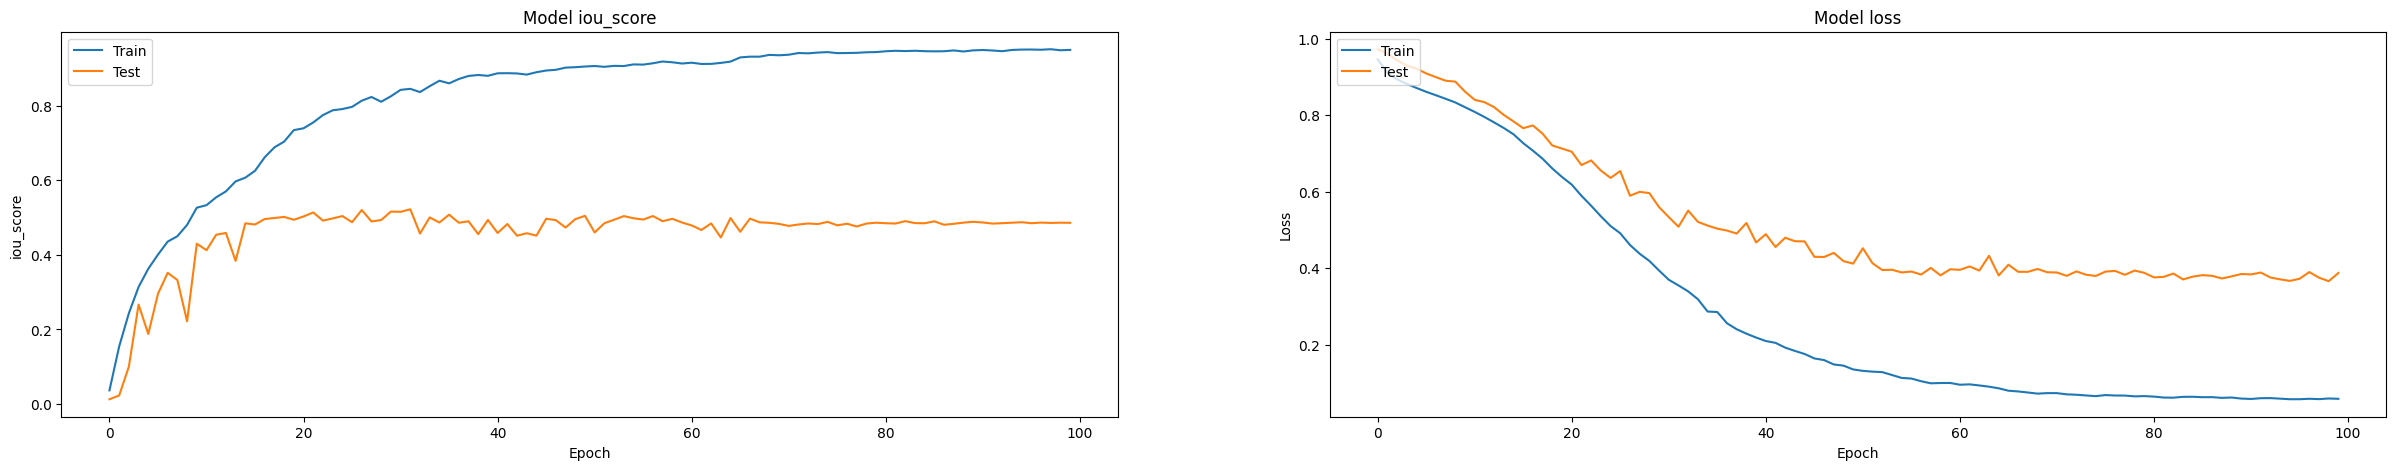

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
model.save("modelUnet.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class5_def/24.png
1/1 [==============================] - 3s 3s/step


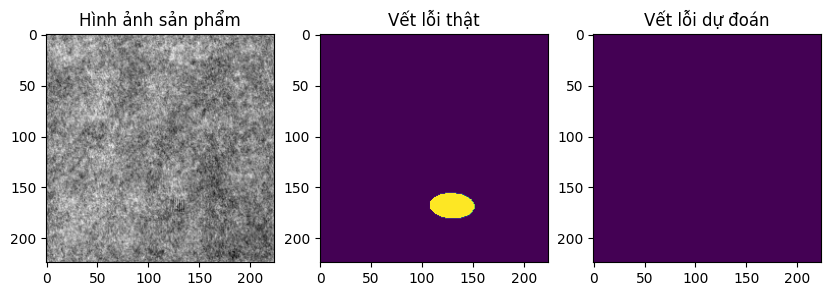

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class2_def/18.png
1/1 [==============================] - 0s 27ms/step


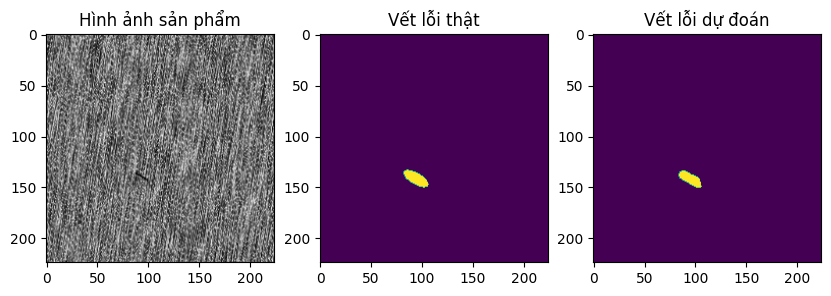

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class6/700.png
1/1 [==============================] - 0s 26ms/step


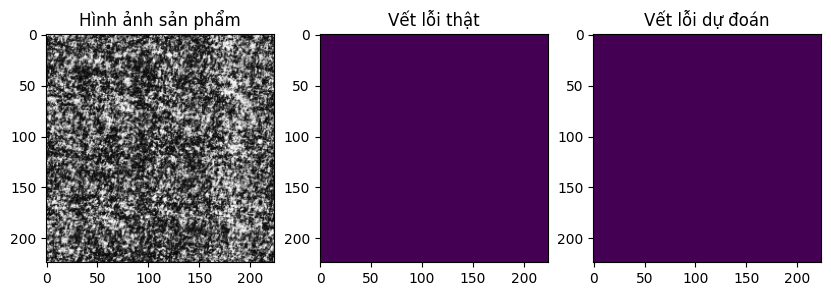

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class6_def/39.png
1/1 [==============================] - 0s 29ms/step


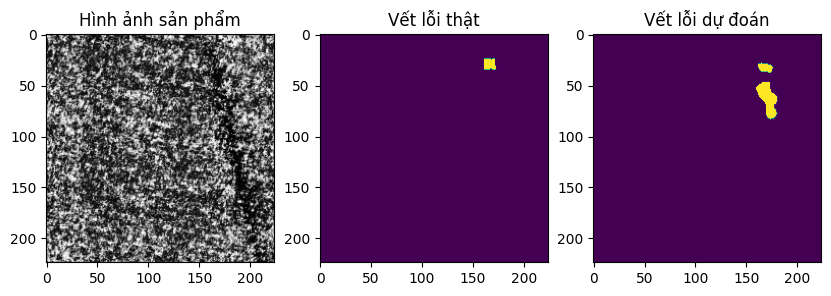

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class3/163.png
1/1 [==============================] - 0s 24ms/step


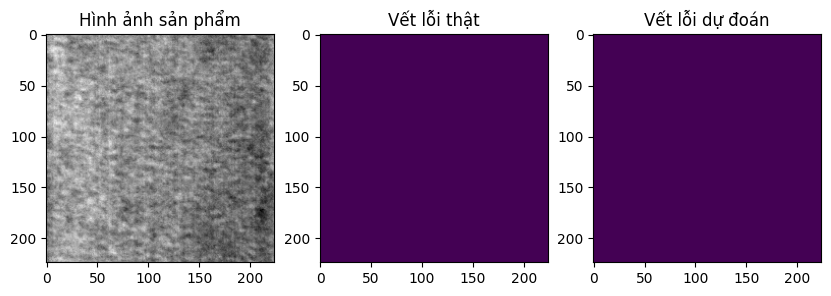

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class3/379.png
1/1 [==============================] - 0s 26ms/step


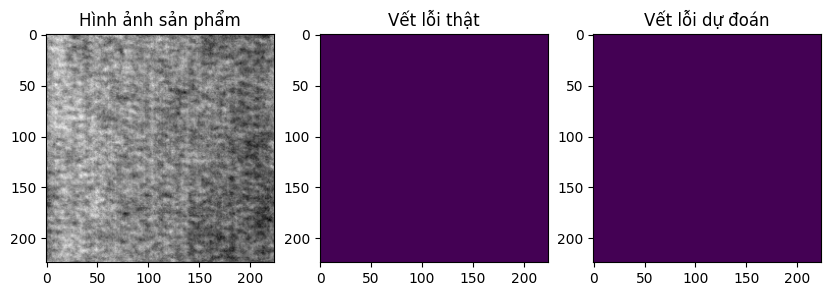

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class2/453.png
1/1 [==============================] - 0s 25ms/step


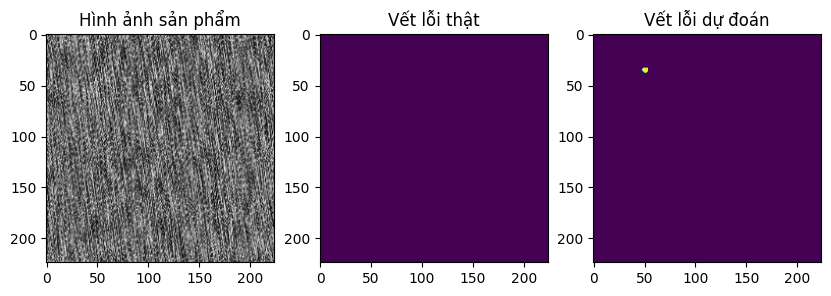

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class2/950.png
1/1 [==============================] - 0s 25ms/step


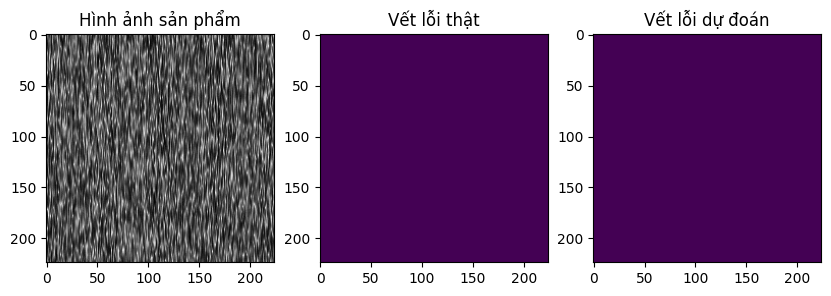

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class5/283.png
1/1 [==============================] - 0s 27ms/step


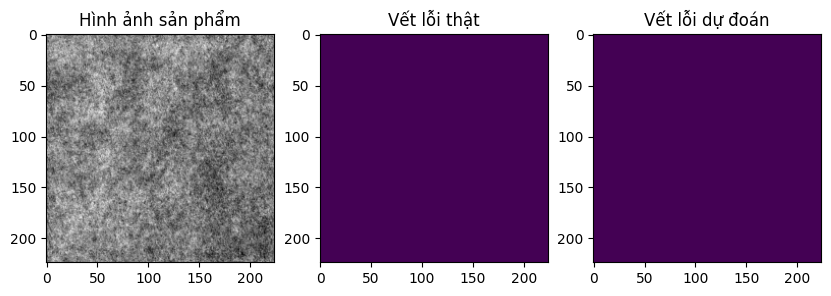

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class5/789.png
1/1 [==============================] - 0s 25ms/step


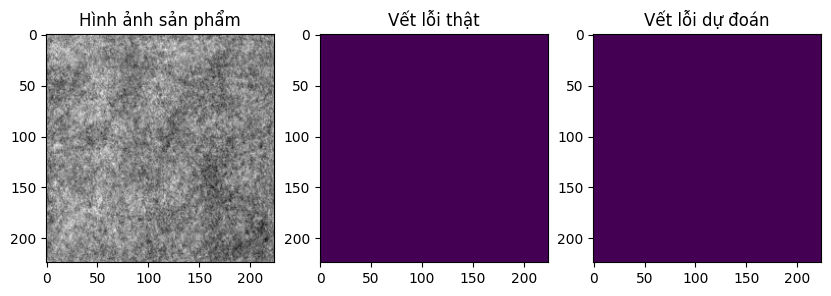

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class6/163.png
1/1 [==============================] - 0s 27ms/step


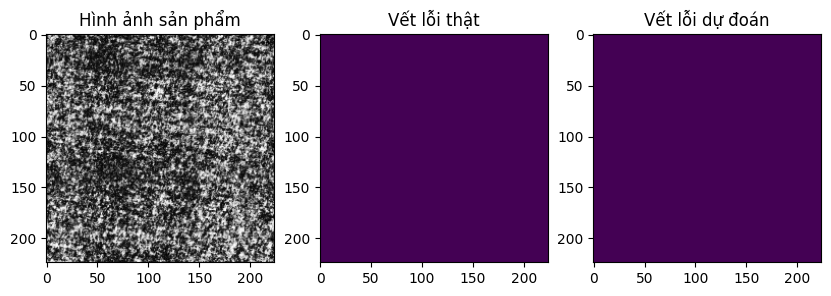

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class3_def/76.png
1/1 [==============================] - 0s 26ms/step


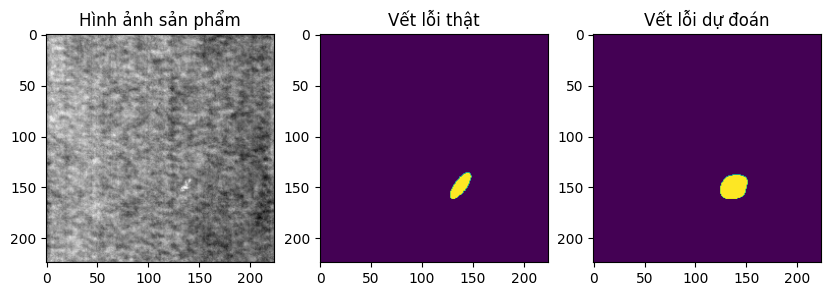

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class1_def/27.png
1/1 [==============================] - 0s 26ms/step


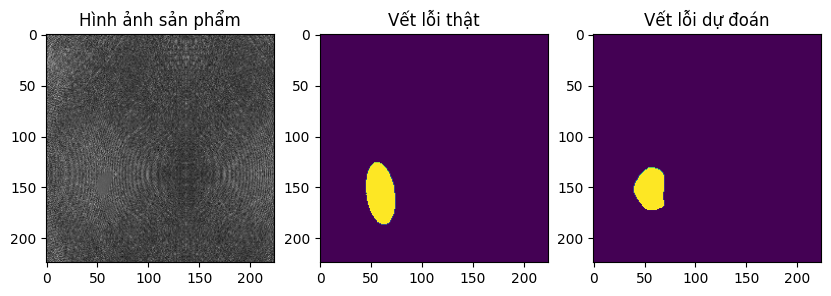

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class5/48.png
1/1 [==============================] - 0s 26ms/step


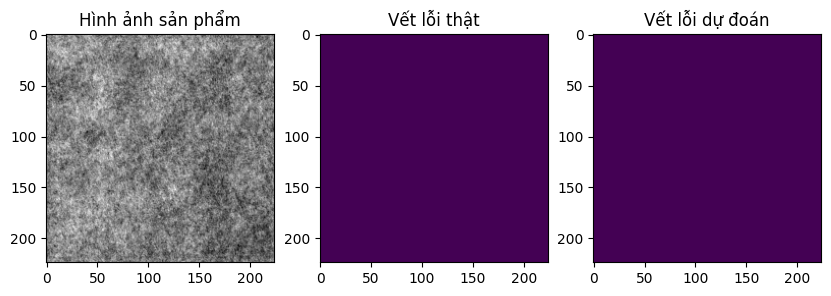

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class3_def/55.png
1/1 [==============================] - 0s 24ms/step


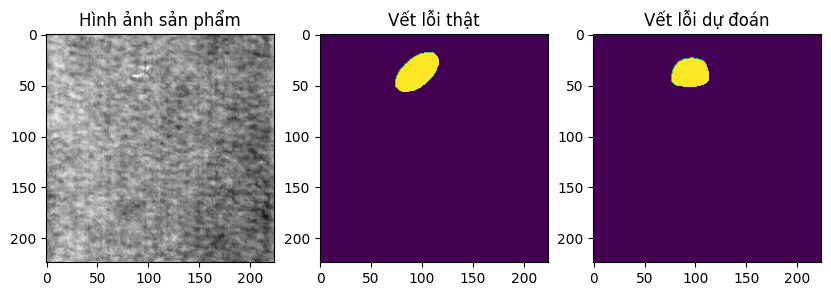

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class2/1.png
1/1 [==============================] - 0s 24ms/step


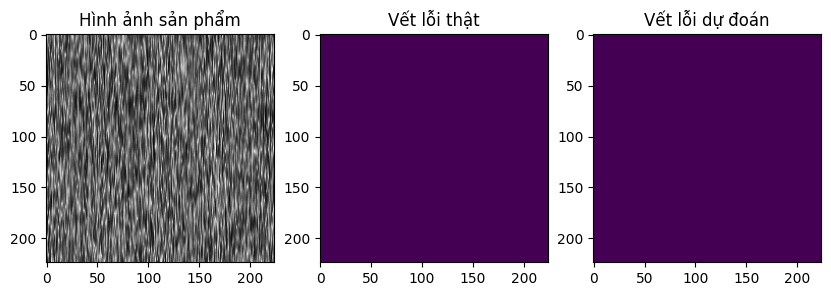

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class5_def/134.png
1/1 [==============================] - 0s 23ms/step


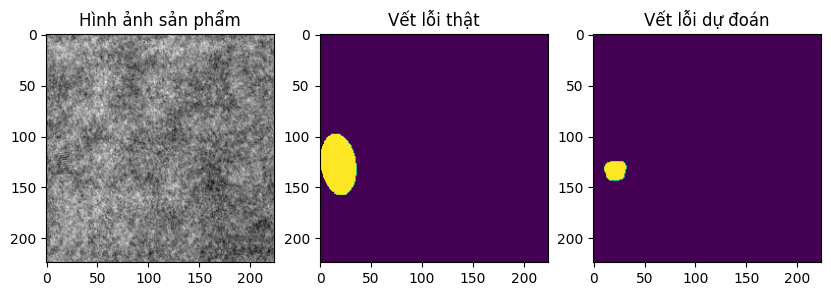

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class2_def/106.png
1/1 [==============================] - 0s 24ms/step


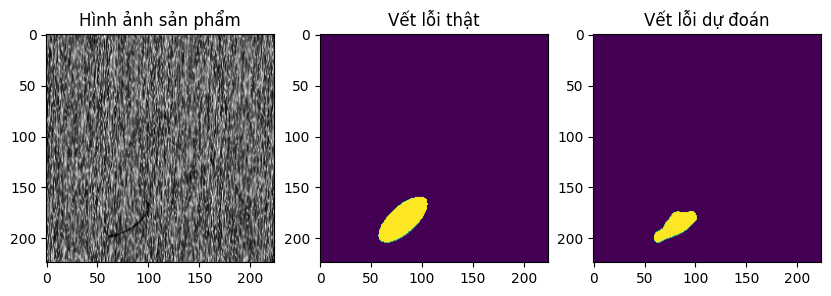

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class4/455.png
1/1 [==============================] - 0s 24ms/step


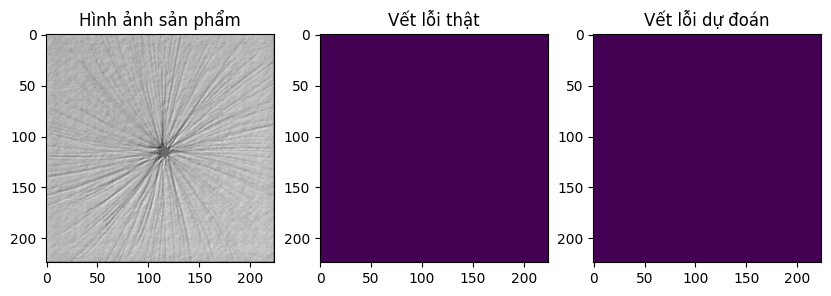

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class1_def/81.png
1/1 [==============================] - 0s 25ms/step


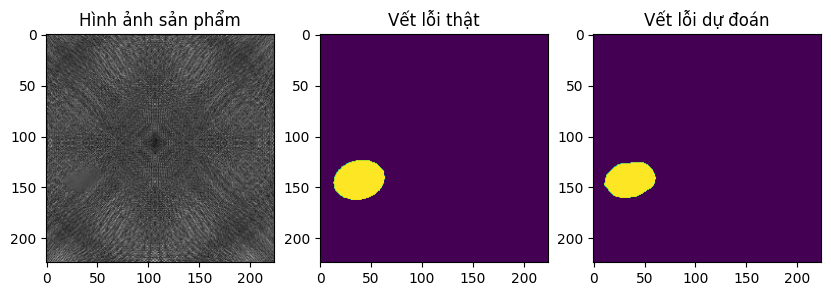

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class6/773.png
1/1 [==============================] - 0s 25ms/step


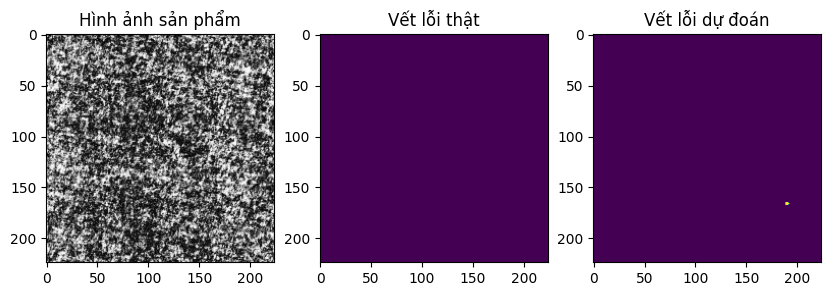

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class4/294.png
1/1 [==============================] - 0s 25ms/step


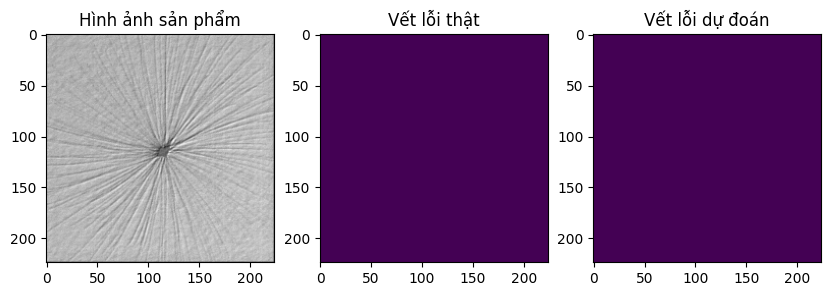

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class4_def/126.png
1/1 [==============================] - 0s 24ms/step


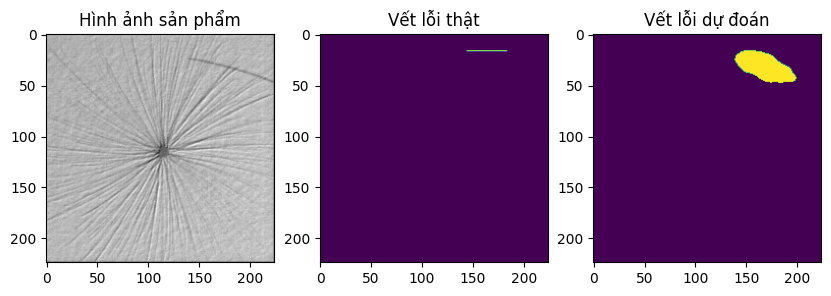

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class5/865.png
1/1 [==============================] - 0s 26ms/step


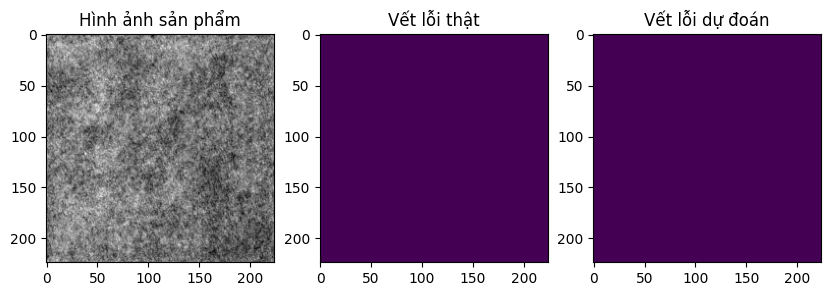

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class6/561.png
1/1 [==============================] - 0s 26ms/step


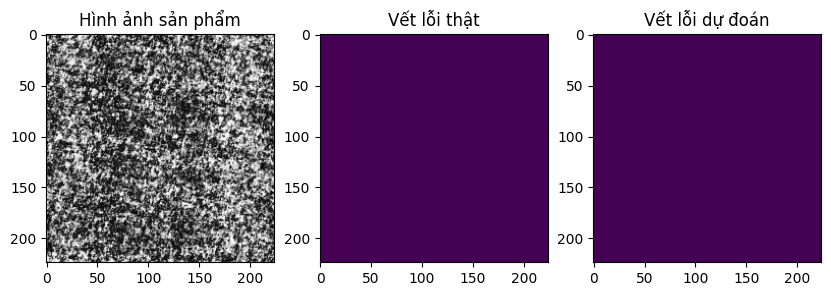

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class2_def/98.png
1/1 [==============================] - 0s 25ms/step


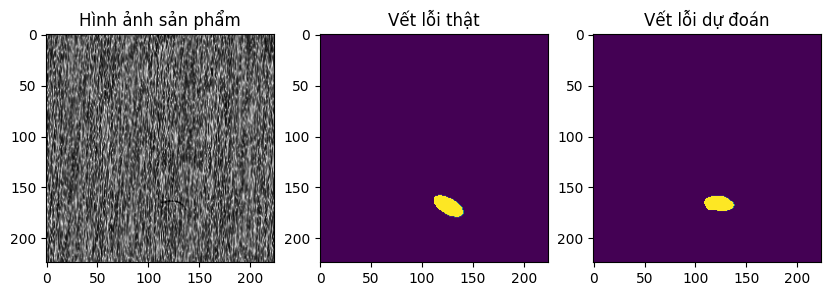

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class4_def/7.png
1/1 [==============================] - 0s 25ms/step


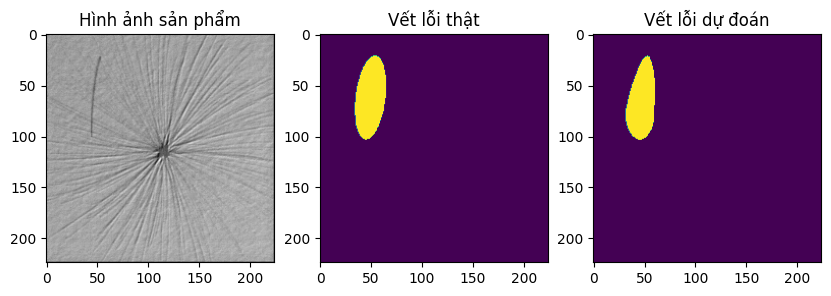

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class3/756.png
1/1 [==============================] - 0s 25ms/step


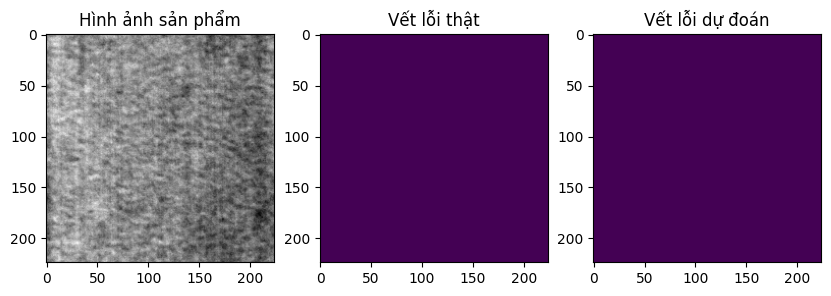

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class5_def/133.png
1/1 [==============================] - 0s 26ms/step


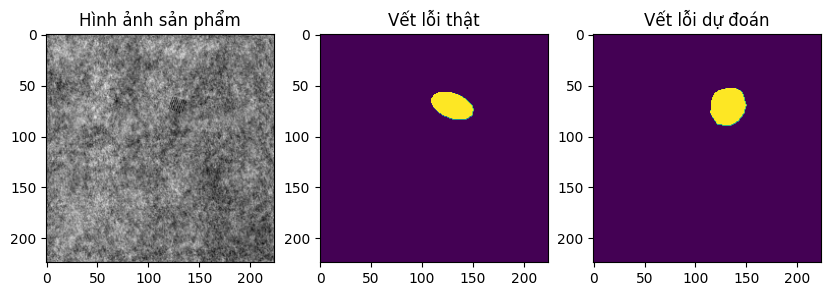

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class5/612.png
1/1 [==============================] - 0s 25ms/step


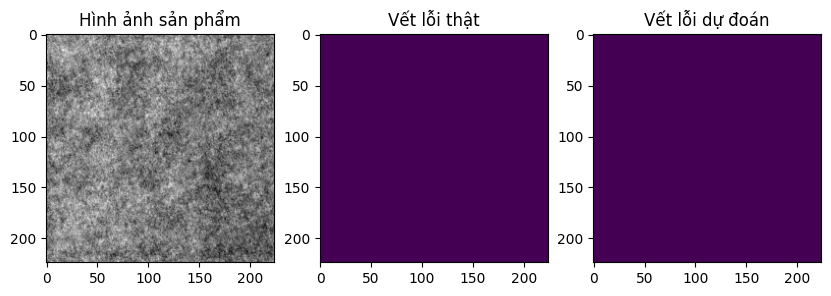

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class1/28.png
1/1 [==============================] - 0s 25ms/step


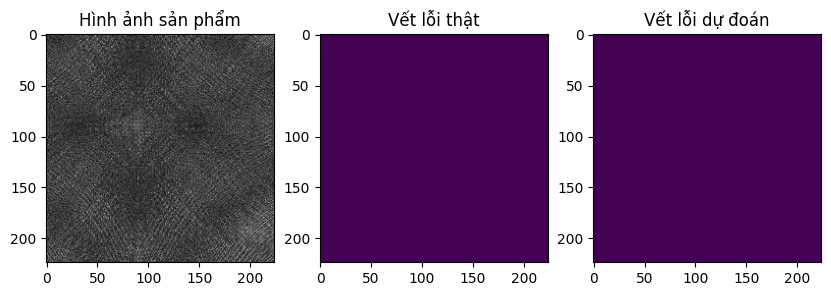

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class6_def/87.png
1/1 [==============================] - 0s 25ms/step


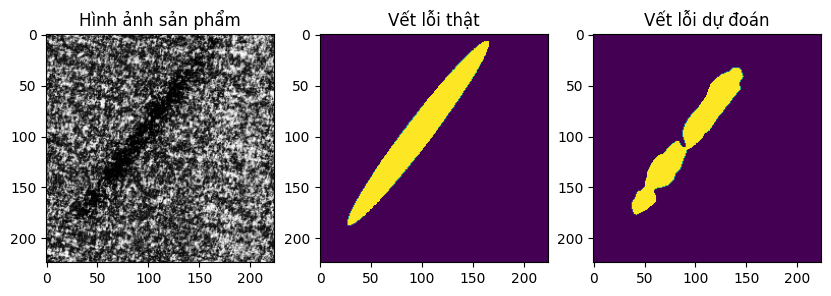

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class2_def/130.png
1/1 [==============================] - 0s 26ms/step


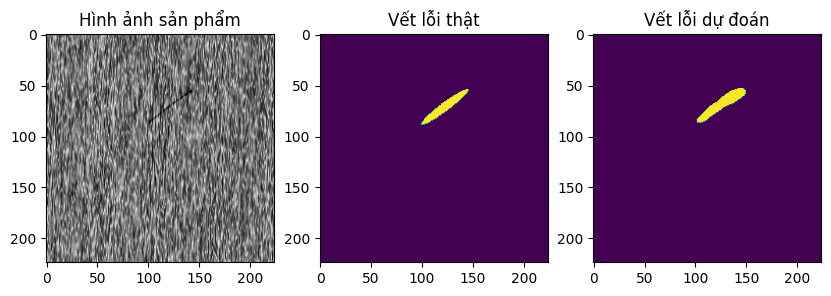

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class4_def/139.png
1/1 [==============================] - 0s 28ms/step


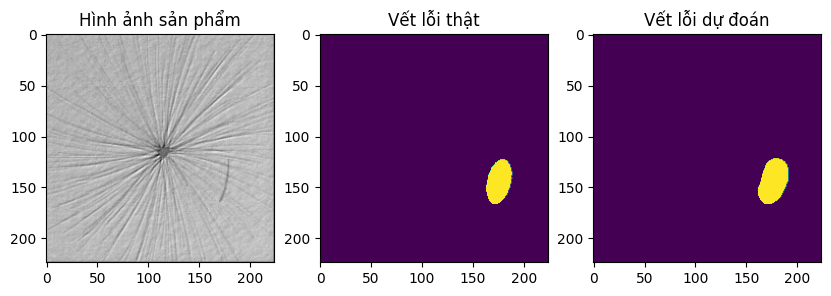

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class4/599.png
1/1 [==============================] - 0s 31ms/step


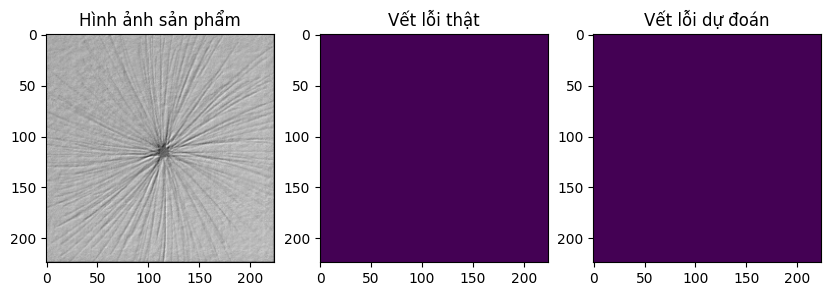

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class5/671.png
1/1 [==============================] - 0s 27ms/step


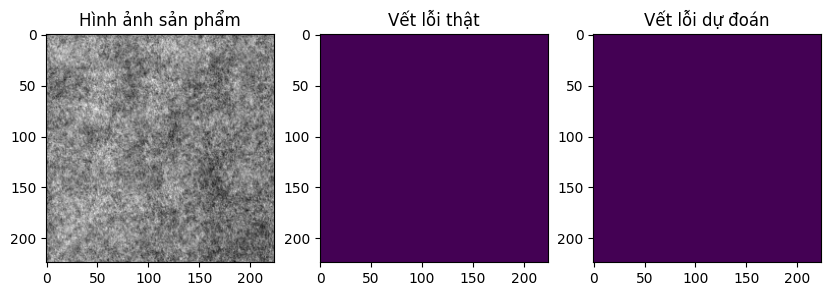

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class3/464.png
1/1 [==============================] - 0s 31ms/step


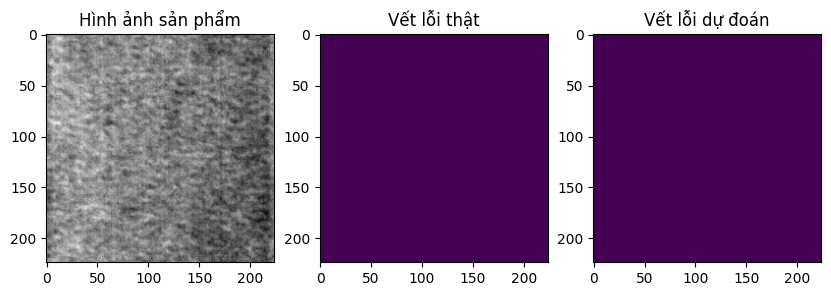

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class5_def/7.png
1/1 [==============================] - 0s 26ms/step


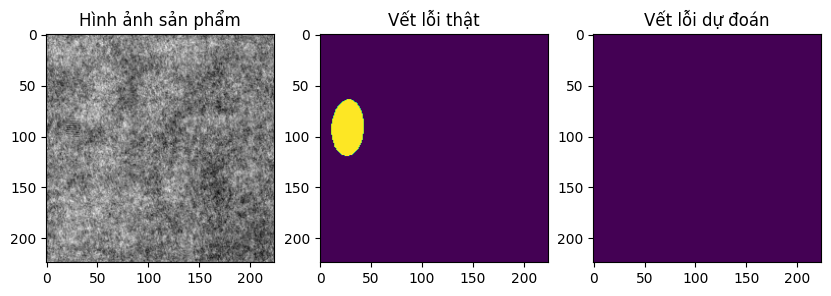

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class2/498.png
1/1 [==============================] - 0s 24ms/step


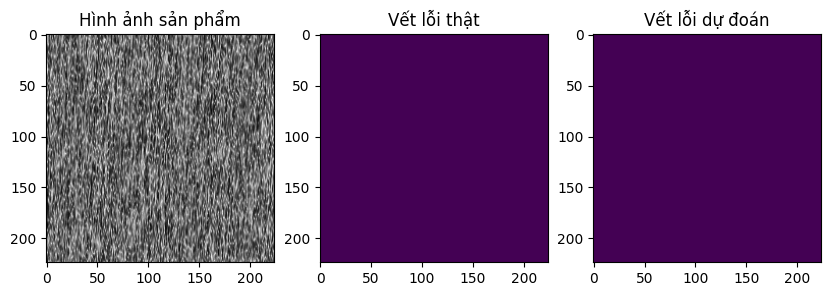

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class5/500.png
1/1 [==============================] - 0s 25ms/step


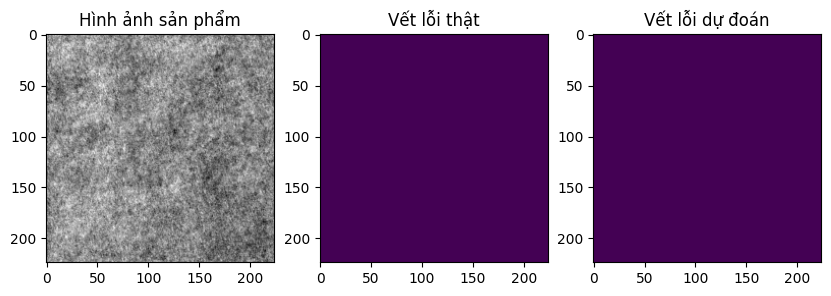

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class1/582.png
1/1 [==============================] - 0s 24ms/step


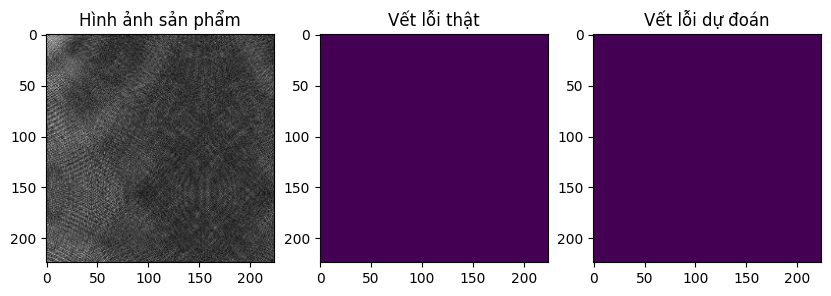

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class6_def/90.png
1/1 [==============================] - 0s 26ms/step


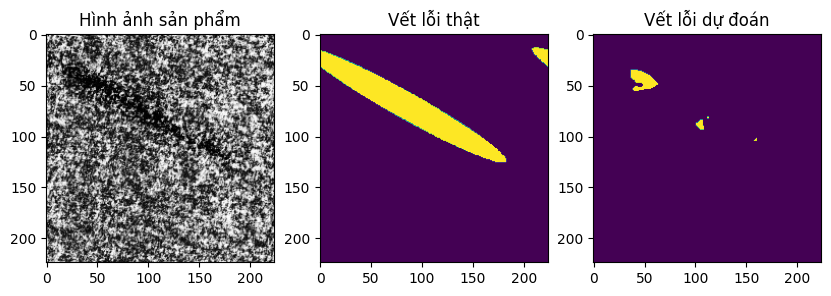

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class3/261.png
1/1 [==============================] - 0s 25ms/step


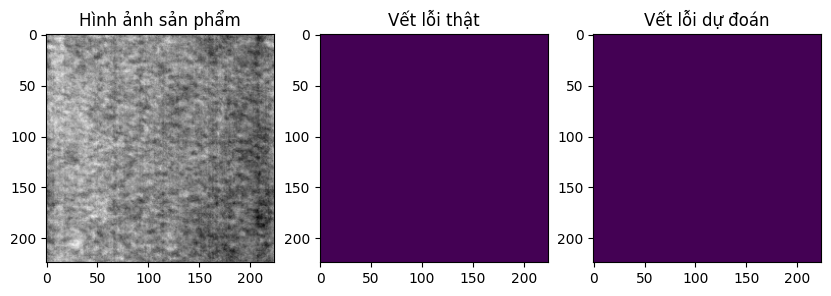

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class2/27.png
1/1 [==============================] - 0s 26ms/step


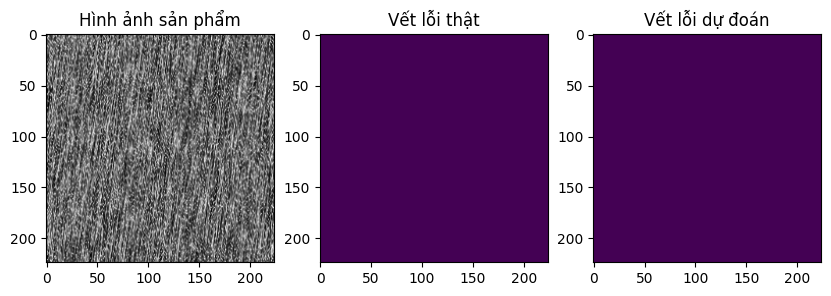

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class4_def/38.png
1/1 [==============================] - 0s 28ms/step


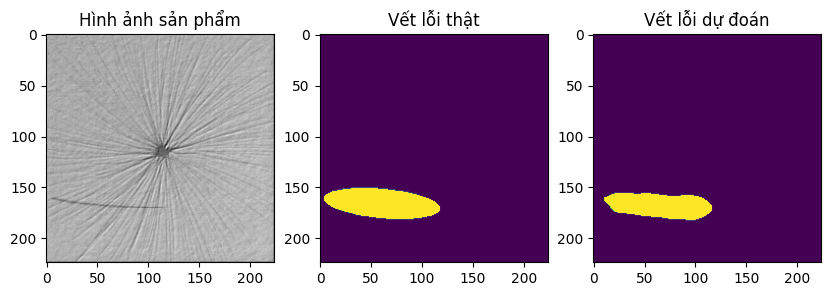

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class6_def/17.png
1/1 [==============================] - 0s 25ms/step


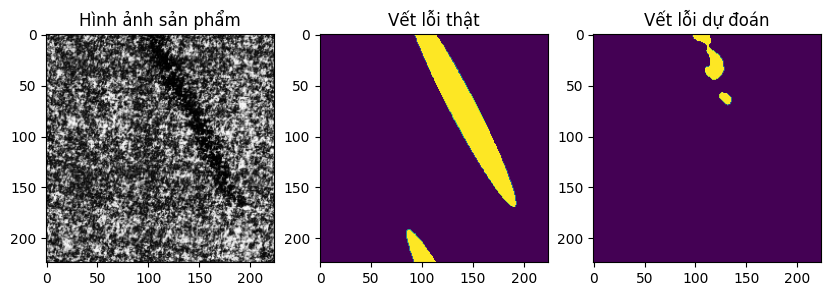

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class5_def/5.png
1/1 [==============================] - 0s 27ms/step


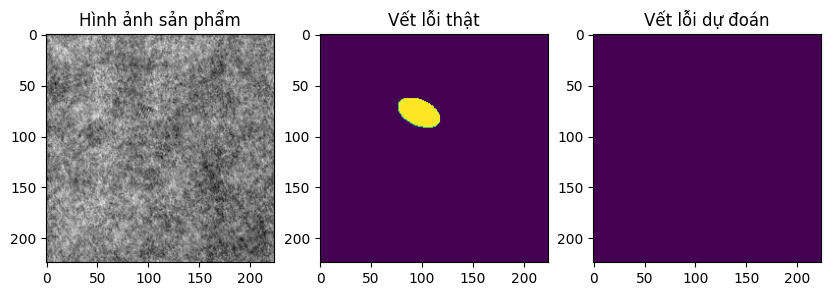

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class5/393.png
1/1 [==============================] - 0s 26ms/step


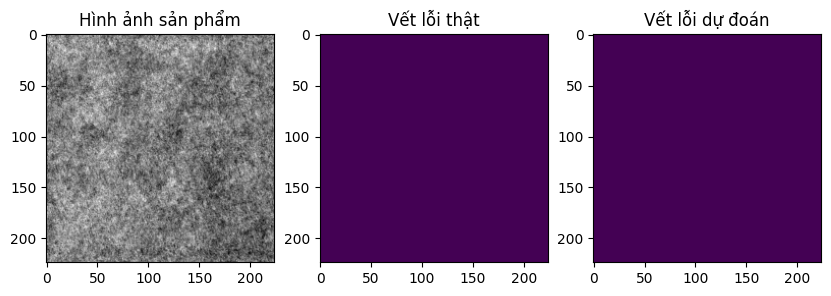

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class3/642.png
1/1 [==============================] - 0s 26ms/step


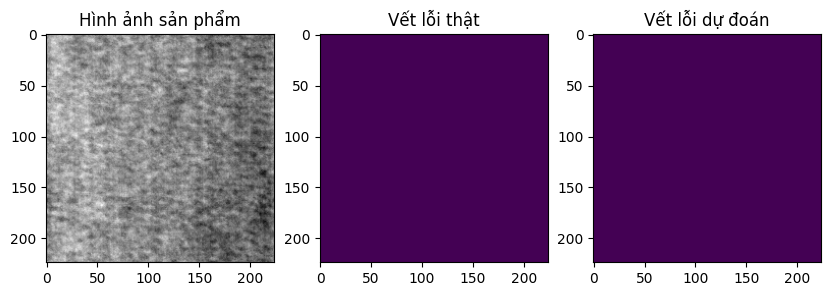

/content/drive/MyDrive/AI/CPP/Unet detection/dataset/Class4/881.png
1/1 [==============================] - 0s 26ms/step


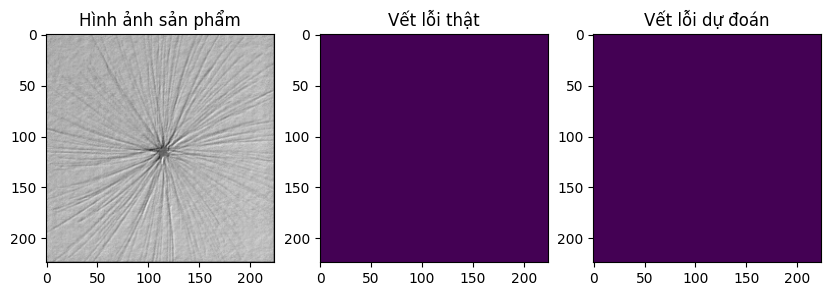

In [ ]:
ids = range(len(image_test))
index = random.sample(ids, 50)

import matplotlib.pyplot as plt

for id in index:
    print(image_test[id])
    image = cv2.imread(image_test[id])
    image = cv2.resize(image, (224, 224))
 
    mask_predict = model.predict(image[np.newaxis, :, :, :])
    mask_predict = (mask_predict > 0.1).astype(np.uint8)
  
    image_mask = cv2.imread(mask_test[id], cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (224, 224))

    plt.figure(figsize=(10, 6))
    plt.subplot(131)
    plt.title("Hình ảnh sản phẩm")
    plt.imshow(image)
    plt.subplot(132)
    plt.title("Vết lỗi thật")
    plt.imshow(image_mask)
    plt.subplot(133)
    plt.title("Vết lỗi dự đoán")
    z = mask_predict[0]#[:, :, 0]
    plt.imshow(z)
    plt.show()